In [176]:
# 1: no
# 2
import numpy as np
from collections import Counter

def Gini_impurity(weights, y):
    """Calculate Gini index of all y with weight"""
    g = 0
    for k in np.unique(y):
        w_k = weights[y == k]
        pk = np.sum(w_k)
        g += pk ** 2
    return 1 - g

class Stump:
    def fit(self, X: np.ndarray, y: np.ndarray, weights: np.ndarray=None):
        """Fit Stump with data and weights"""
        weights = np.ones(len(y)) / len(y) if weights is None else weights
        self.w = weights
        # Loop throuph every feature
        splits = []
        for i in range(X.shape[1]):
            # Find the best split in this feature
            x = X[:,i]
            v, Gini, preds = self.best_split(x, y, weights)
            splits.append([v, Gini, preds[0], preds[1]])
        # Choose best split
        feat_ind = np.argmin(np.array(splits)[:,1])
        val = splits[feat_ind][0]
        preds = splits[feat_ind][2:4]

        self.split_feature = feat_ind
        self.split_value = val
        self.less = preds[0]
        self.greater = preds[1]

        return self
    
    def best_split(self, x, y, w) -> (float, float, (int, int)):
        """Returns the x and Gini value that would result in the best gini split"""
        # 1. Get unique x values
        x_unq = np.unique(x)
        # 2. Get the value between every pair (e.g. [1, 2, 3] -> [1.5, 2.5])
        diff = np.diff(x_unq)
        vals = x_unq[:-1] + diff / 2
        # 3. Calculate the weighted Gini at every split
        splits = []
        for val in vals:
            # 3.1. Do the split
            y_le, w_le = np.c_[y, w][x < val].T # Find x values less than val, and get corresponding y and weights.
            y_ge, w_ge = np.c_[y, w][x > val].T
            y_le, y_ge = y_le.astype(int), y_ge.astype(int)
            # 3.2 Calculate Gini for each split
            Gini_le = Gini_impurity(w_le, y_le)
            Gini_ge = Gini_impurity(w_ge, y_ge)
            # 3.3 Weighted avreage Gini
            tot = len(y)
            Gini_we = (len(y_le) / tot) * Gini_le + (len(y_ge) / tot) * Gini_ge
            # 3.4 Get most common class in each split for later
            yh_le = Counter(y_le).most_common(1)[0][0] # https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
            yh_ge = Counter(y_ge).most_common(1)[0][0]
            splits.append((val, Gini_we, (yh_le, yh_ge)))
        # 4. Select the split with the highest Gini
        return min(splits, key=lambda x: x[1])

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict after fit"""
        assert self.split_feature is not None, "Cannot call predict() before fit()"
        X = np.array(X) # make sure we can do numpy stuff

        # Get feature
        x = X[:,self.split_feature]
        # Create predictions
        preds = np.ones(len(x)) * self.less # Smaller than split
        preds[x > self.split_value] = self.greater # Bigger than split
        return preds.astype(int)

In [182]:
class AdaBoost:
    def __init__(self, learn_rate, depth=3) -> None:
        self.depth = depth
        self.lr = learn_rate
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        stumps = []
        weights = np.ones(len(y)) / len(y)
        for i in range(self.depth):
            stump = Stump()
            stump.fit(X, y, weights)
            preds = stump.predict(X)
            # Find errors
            err_inds = (preds != y).nonzero()
            err_weights = weights[err_inds]
            total_err = sum(err_weights)
            model_influence = self.lr * np.log((1-total_err) / total_err)

            # Update and normalise weights
            weights[err_inds] = weights[err_inds] * (np.e ** model_influence)
            weights = weights / sum(weights)
            # Save models
            stumps.append({
                "model": stump,
                "influence": model_influence
            })
        
        self.stumps = stumps
    
    def predict(self, X: np.ndarray):
        assert self.stumps is not None, "Cannot call predict() before fit()"
        X = np.array(X)

        pred = sum([s['model'].predict(X)*s['influence'] for s in self.stumps])
        return np.sign(pred)


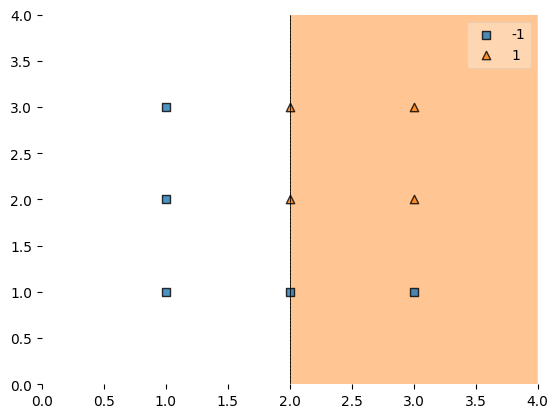

In [190]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

data = np.array([
    [1, 3, -1], [2, 3,  1], [3, 3,  1],
    [1, 2, -1], [2, 2,  1], [3, 2,  1],
    [1, 1, -1], [2, 1, -1], [3, 1, -1]
])

X = data[:,:2]
y = data[:,2].astype(int)
learn_rate = 0.5
boost = AdaBoost(learn_rate)
boost.fit(X, y)

plot_decision_regions(X, y, clf=boost)
plt.show()
# idk what i did wrong but im done debuggind this shit

In [198]:
# 4
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
data = pd.read_csv('Ex1-training.csv')
data.head()
X = data[['x1', 'x2']].to_numpy()
y = data['y'].to_numpy()
data.head()

,y,x1,x2
0,1,0.505022,4.106225
1,1,0.965577,4.881722
2,1,1.132776,4.324086
3,1,0.454710,4.684511
4,1,0.157760,3.599274


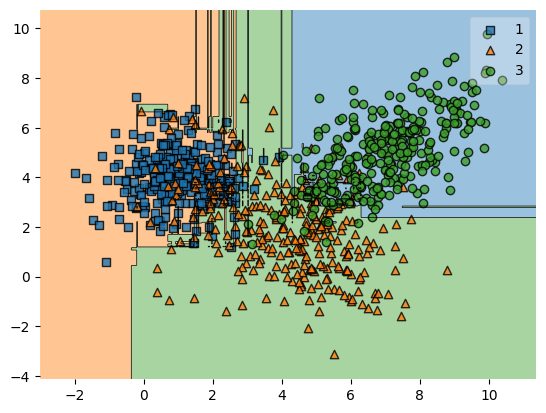

In [201]:
clf = GradientBoostingClassifier(max_depth=3).fit(X, y)
plot_decision_regions(X, y, clf=clf)
plt.show()
# one of the trees of all time